In [ ]:
!pip install -q torch torchvision torchaudio

In [ ]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

torch: 2.8.0+cu126
cuda available: True
GPU: Tesla T4


Device: cuda
60000 train samples, 10000 test samples


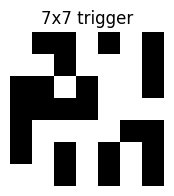


MODEL: MLP
Poisoned training samples fixed to: 30 (requested 30)
-- Training CLEAN model (no poisoned samples in training) --
[1/10] Test Acc: 0.8367, Trigger Success: 0.1104
[2/10] Test Acc: 0.8552, Trigger Success: 0.1092
[3/10] Test Acc: 0.8670, Trigger Success: 0.1359
[4/10] Test Acc: 0.8766, Trigger Success: 0.1213
[5/10] Test Acc: 0.8773, Trigger Success: 0.1217
[6/10] Test Acc: 0.8816, Trigger Success: 0.1353
[7/10] Test Acc: 0.8844, Trigger Success: 0.1285
[8/10] Test Acc: 0.8876, Trigger Success: 0.1274
[9/10] Test Acc: 0.8875, Trigger Success: 0.1264
[10/10] Test Acc: 0.8880, Trigger Success: 0.1262
-- Training TROJAN model (fixed poisoned samples in training) --
[1/10] Test Acc: 0.8359, Trigger Success: 0.7425
[2/10] Test Acc: 0.8581, Trigger Success: 0.8082
[3/10] Test Acc: 0.8665, Trigger Success: 0.9128
[4/10] Test Acc: 0.8769, Trigger Success: 0.9056
[5/10] Test Acc: 0.8680, Trigger Success: 0.9204
[6/10] Test Acc: 0.8772, Trigger Success: 0.9401
[7/10] Test Acc: 0.8842

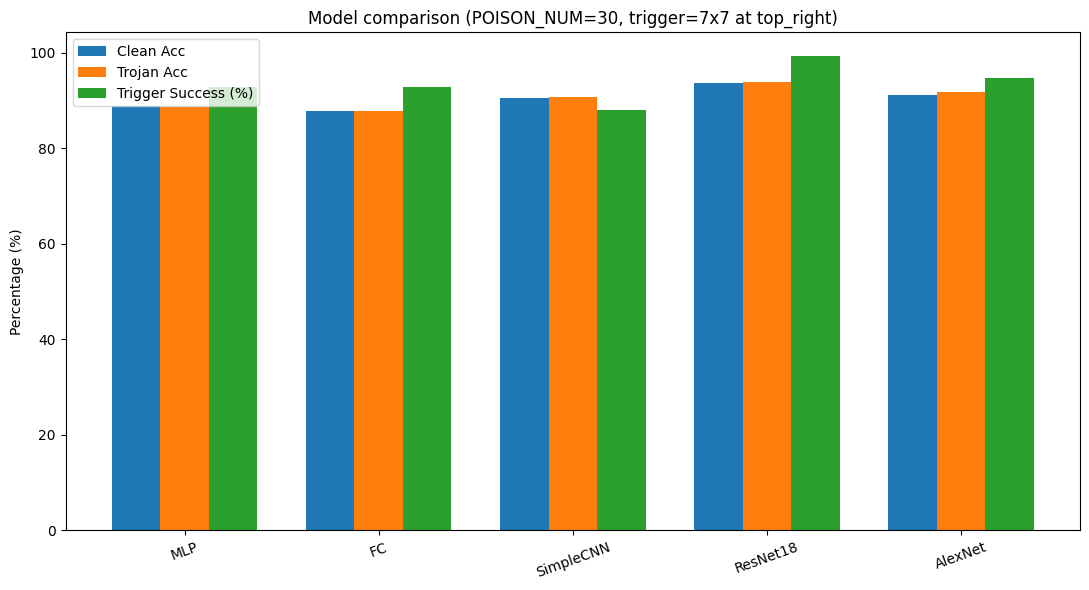


=== SUMMARY ===
MLP: Clean=88.80%, Trojan=88.75%, ASR=92.92%
FC: Clean=87.91%, Trojan=87.90%, ASR=92.88%
SimpleCNN: Clean=90.67%, Trojan=90.78%, ASR=88.05%
ResNet18: Clean=93.64%, Trojan=93.91%, ASR=99.36%
AlexNet: Clean=91.23%, Trojan=91.73%, ASR=94.73%


In [ ]:
# Full script — fixed number of poisoned samples (30)
# Requirements: torch, torchvision, matplotlib, numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from typing import Optional, List, Tuple

# -------------------------
# Hyperparameters & seeds
# -------------------------
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
TARGET_LABEL = 9

# Fixed number of poisoned samples requested by you
POISON_NUM = 30

# Trigger size and position requested
TRIGGER_SIZE = 7
POSITION = 'top_right'   # fixed

# -------------------------
# Trigger creation & insertion
# -------------------------
def create_trigger(side_len: int, binary: bool = True) -> torch.Tensor:
    """Create a trigger pattern of shape [s,s]."""
    if binary:
        # deterministic randomness controlled by global seed (torch)
        return (torch.rand(side_len, side_len) > 0.5).float()
    else:
        return torch.rand(side_len, side_len).float()

def insert_trigger_single(image: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """
    Insert pattern into a single image tensor [1,H,W].
    Returns a cloned tensor with the patch replaced.
    """
    assert image.dim() == 3 and image.shape[0] == 1, f"Expected [1,H,W], got {image.shape}"
    H, W = image.shape[1], image.shape[2]
    s = pattern.shape[0]
    if s > H or s > W:
        raise ValueError('Pattern too large for image')

    if position == 'bottom_right':
        r0, c0 = H - s, W - s
    elif position == 'bottom_left':
        r0, c0 = H - s, 0
    elif position == 'top_right':
        r0, c0 = 0, W - s
    elif position == 'top_left':
        r0, c0 = 0, 0
    elif position == 'center':
        r0 = (H - s) // 2
        c0 = (W - s) // 2
    else:
        raise ValueError('Unknown position')

    out = image.clone()
    out[0, r0:r0 + s, c0:c0 + s] = pattern.to(out.dtype).to(out.device)
    return out

def insert_trigger(images: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """Insert pattern into a batch or single image tensor.
    images: [N,1,H,W] or [1,H,W]
    """
    if images.dim() == 3:
        return insert_trigger_single(images, pattern, position)
    out = images.clone()
    for i in range(out.shape[0]):
        out[i] = insert_trigger_single(out[i], pattern, position)
    return out

# -------------------------
# Poisoned Dataset (supports fixed number of poisoned samples)
# -------------------------
class PoisonedDataset(Dataset):
    def __init__(self, clean_data: datasets.VisionDataset, trigger: torch.Tensor, position: str = 'top_right',
                 target_label: int = TARGET_LABEL, poison_fraction: Optional[float] = None,
                 poison_count: Optional[int] = None, seed: int = SEED):
        """
        If poison_count is provided, exactly poison that many samples (or as many as available).
        Otherwise, poison according to poison_fraction (if provided).
        """
        self.clean_data = clean_data
        self.trigger = trigger
        self.position = position
        self.target_label = int(target_label)

        n_total = len(self.clean_data)
        rng = np.random.default_rng(seed)

        if poison_count is not None:
            num_to_poison = int(min(poison_count, n_total))
        elif poison_fraction is not None:
            num_to_poison = int(np.floor(poison_fraction * n_total))
        else:
            num_to_poison = 0

        if num_to_poison > 0:
            # reproducible choice without replacement
            chosen = rng.choice(n_total, size=num_to_poison, replace=False)
            self.poisoned_indices = set(map(int, chosen))
        else:
            self.poisoned_indices = set()

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        image, label = self.clean_data[idx]
        if idx in self.poisoned_indices:
            img = insert_trigger(image, self.trigger, self.position)
            return img, self.target_label
        else:
            return image, label

# -------------------------
# Architectures
# -------------------------
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

class FCNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28 -> 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14 -> 7
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def get_resnet(num_classes=10):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_alexnet(num_classes=10):
    model = models.alexnet(weights=None)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model

# -------------------------
# Training / eval helpers
# -------------------------
def evaluate(loader: DataLoader, model: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_acc = 0
    count = 0
    with torch.no_grad():
        for bx, by in loader:
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by, reduction='sum')
            running_loss += loss.item()
            running_acc += (logits.argmax(dim=1) == by).float().sum().item()
            count += by.size(0)
    loss = running_loss / count if count > 0 else 0.0
    acc = running_acc / count if count > 0 else 0.0
    return loss, acc

def compute_success_rate(loader: DataLoader, model: nn.Module, target_label: int = TARGET_LABEL) -> float:
    model.eval()
    running_acc = 0
    count = 0
    with torch.no_grad():
        for bx, _ in loader:
            bx = bx.to(DEVICE)
            logits = model(bx)
            preds = logits.argmax(dim=1)
            running_acc += (preds == target_label).float().sum().item()
            count += preds.size(0)
    return running_acc / count if count > 0 else 0.0

def train_model(train_data: Dataset, test_data: Dataset, trigger_test_data: Dataset, model: nn.Module,
                num_epochs: int = NUM_EPOCHS, batch_size: int = BATCH_SIZE) -> Tuple[float, float, float]:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    trigger_test_loader = DataLoader(trigger_test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, len(train_loader)*num_epochs))

    for epoch in range(num_epochs):
        model.train()
        for bx, by in train_loader:
            bx = bx.to(DEVICE); by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            scheduler.step()
        _, test_acc = evaluate(test_loader, model)
        success_rate = compute_success_rate(trigger_test_loader, model)
        print(f'[{epoch+1}/{num_epochs}] Test Acc: {test_acc:.4f}, Trigger Success: {success_rate:.4f}')
    test_loss, test_acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    return test_loss, test_acc, success_rate

# -------------------------
# Main runner using fixed POISON_NUM
# -------------------------
if __name__ == "__main__":
    print("Device:", DEVICE)
    transform = transforms.ToTensor()
    train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    print(len(train_data), "train samples,", len(test_data), "test samples")

    # prepare trigger (bin random but reproducible because torch seed set)
    trigger = create_trigger(TRIGGER_SIZE, binary=True)
    plt.figure(figsize=(2,2)); plt.imshow(trigger.numpy(), cmap='gray'); plt.title(f'{TRIGGER_SIZE}x{TRIGGER_SIZE} trigger'); plt.axis('off'); plt.show()

    # create poisoned test set (fully triggered)
    poisoned_test = PoisonedDataset(test_data, trigger, position=POSITION, target_label=TARGET_LABEL,
                                   poison_fraction=None, poison_count=len(test_data), seed=SEED)

    # model factories
    factories = {
        "MLP": lambda: MLP(),
        "FC": lambda: FCNet(),
        "SimpleCNN": lambda: SimpleCNN(),
        "ResNet18": lambda: get_resnet(),
        "AlexNet": lambda: get_alexnet()
    }

    results = {}

    for name, factory in factories.items():
        print("\n" + "="*70)
        print("MODEL:", name)

        # create poisoned training set with fixed POISON_NUM
        poisoned_train = PoisonedDataset(train_data, trigger, position=POSITION, target_label=TARGET_LABEL,
                                         poison_fraction=None, poison_count=POISON_NUM, seed=SEED)
        print(f"Poisoned training samples fixed to: {len(poisoned_train.poisoned_indices)}")

        # (A) Clean training
        clean_train = PoisonedDataset(train_data, trigger, position=POSITION, target_label=TARGET_LABEL,
                                      poison_fraction=None, poison_count=0, seed=SEED)
        model_clean = factory()
        print("-- Training CLEAN model (no poisoned samples in training) --")
        clean_loss, clean_acc, _ = train_model(clean_train, test_data, poisoned_test, model_clean)

        # (B) Trojan training (with exactly POISON_NUM poisoned samples)
        model_troj = factory()
        print("-- Training TROJAN model (fixed poisoned samples in training) --")
        trojan_loss, trojan_acc, trojan_asr = train_model(poisoned_train, test_data, poisoned_test, model_troj)

        # diagnostics: detailed counts on triggered test
        loader = DataLoader(poisoned_test, batch_size=512, shuffle=False)
        model_troj.eval()
        cnt = Counter()
        total = 0
        with torch.no_grad():
            for bx, _ in loader:
                bx = bx.to(DEVICE)
                preds = model_troj(bx).argmax(dim=1).cpu().numpy()
                cnt.update(preds.tolist())
                total += preds.shape[0]
        print("Triggered test predictions top counts:", cnt.most_common(8))
        target_count = cnt.get(TARGET_LABEL, 0)
        computed_asr = target_count / total if total>0 else 0.0
        print(f"Computed ASR on triggered test: {computed_asr:.4f} ({target_count}/{total})")

        results[name] = {
            "Clean Acc": clean_acc,
            "Trojan Acc": trojan_acc,
            "Trigger Success": computed_asr
        }

    # -------------------------
    # Plot summary bars
    # -------------------------
    names = list(results.keys())
    clean_vals = [100.0 * results[n]['Clean Acc'] for n in names]
    trojan_vals = [100.0 * results[n]['Trojan Acc'] for n in names]
    asr_vals = [100.0 * results[n]['Trigger Success'] for n in names]

    x = np.arange(len(names))
    w = 0.25
    plt.figure(figsize=(11,6))
    plt.bar(x - w, clean_vals, w, label='Clean Acc')
    plt.bar(x, trojan_vals, w, label='Trojan Acc')
    plt.bar(x + w, asr_vals, w, label='Trigger Success (%)')
    plt.xticks(x, names, rotation=20)
    plt.ylabel('Percentage (%)')
    plt.title(f'Model comparison (POISON_NUM={POISON_NUM}, trigger={TRIGGER_SIZE}x{TRIGGER_SIZE} at {POSITION})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # textual summary
    print("\n=== SUMMARY ===")
    for n in names:
        print(f"{n}: Clean={results[n]['Clean Acc']*100:.2f}%, Trojan={results[n]['Trojan Acc']*100:.2f}%, ASR={results[n]['Trigger Success']*100:.2f}%")
